In [ ]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id='1'></a><br>
# Load and Check Data

In [ ]:
NORMAL = "/content/drive/MyDrive/pneumonia dataset/NORMAL"
PNEUMONIA = "/content/drive/MyDrive/pneumonia dataset/PNEUMONIA"

In [ ]:
def get_path_image(folder):
    image_paths = []
    image_fnames = os.listdir(folder)
    for img_id in range(len(image_fnames)):
        img = os.path.join(folder,image_fnames[img_id])
        image_paths.append(img)

    return image_paths

In [ ]:
img_data = []

for i in [NORMAL, PNEUMONIA]:
    paths = get_path_image(i)
    img_data.extend(paths)
print(len(img_data))

5856


In [ ]:
data = {"img_data":img_data,
        "labels":[np.nan for x in range(len(img_data))]}

data = pd.DataFrame(data)

In [ ]:
data["labels"][0:1583] = 0 # NORMAL
data["labels"][1583:5856] = 1 # PNEUMONIA

<ipython-input-7-db89bdc32fba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["labels"][0:1583] = 0 # NORMAL
<ipython-input-7-db89bdc32fba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["labels"][1583:5856] = 1 # PNEUMONIA


In [ ]:
data["labels"] = data["labels"].astype("int64")

<a id='2'></a><br>
# Crop Black Edges In Image

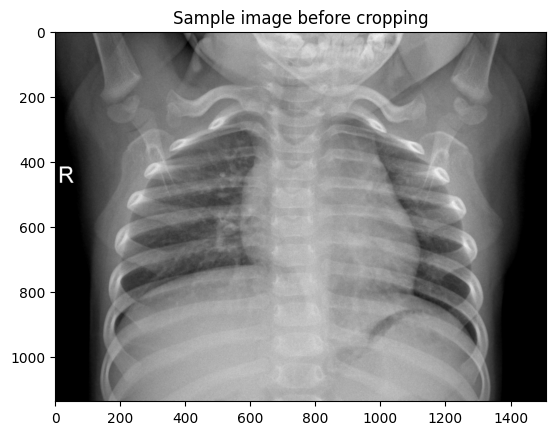

In [ ]:
image = cv.imread(data["img_data"][433])
plt.imshow(image)
plt.title("Sample image before cropping")
plt.show()

In [ ]:
img_list = []
for i in range(len(img_data)):
    image = cv.imread(data["img_data"][i])
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]

    result = cv.bitwise_and(image, image, mask=thresh)
    result[thresh==0] = [255,255,255]
    (x, y, z_) = np.where(result > 0)
    mnx = (np.min(x))
    mxx = (np.max(x))
    mny = (np.min(y))
    mxy = (np.max(y))
    crop_img = image[mnx:mxx,mny:mxy,:]
    crop_img_r = cv.resize(crop_img, (224,224))
    img_list.append(crop_img_r)

<a id='3'></a><br>
# Feature Extraction with VGG16 and MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNet
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization

In [ ]:
input_shape = (224, 224, 3)
inputs = Input(input_shape)

vgg = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
mob = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)

17225924/17225924 [==============================] - 1s 0us/step


In [ ]:
multi_net = Concatenate()([GlobalAveragePooling2D()(vgg), GlobalAveragePooling2D()(mob)])
model = Model(inputs, multi_net)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_1[0][0]']             
                                                          8                                       
                                                                                                  
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)           3228864   ['input_1[0][0]']             
 onal)                                                                                            
                                                                                              

In [ ]:
features_list = []
for i in range(len(img_list)):

    image = img_list[i].reshape(-1, 224, 224, 3)

    features = model.predict(image).reshape(1536,)

    features_list.append(features)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step


In [ ]:
features_df = pd.DataFrame(features_list)

In [ ]:
features_df["labels"] = data["labels"]

In [ ]:
x = features_df.drop(['labels'], axis = 1)
y = features_df.loc[:,"labels"].values

In [ ]:
x

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
0,6.925892,0.000000,2.963357,0.515794,0.463275,0.032126,0.487317,0.942745,0.200480,4.229089,...,0.759456,0.152555,0.000000,0.406549,0.025333,0.113554,1.914488,0.355770,0.078797,0.848888
1,4.276062,1.496347,0.379359,3.912368,0.000000,0.000000,0.576434,1.687522,0.318182,1.044813,...,0.752712,0.070226,0.000116,0.609238,0.009225,0.290020,1.668220,1.027134,0.065560,0.149863
2,5.401083,0.000000,1.022006,0.000000,1.706011,0.000000,1.000487,1.192970,0.636069,0.390371,...,1.577677,0.137170,0.000000,0.823476,0.047224,0.265537,2.069197,1.299054,0.110268,0.538469
3,3.721840,0.000000,2.914103,0.786199,0.204845,0.000000,0.406610,1.912031,2.341543,0.473358,...,0.193701,0.150925,0.000000,0.242579,0.178448,0.206781,2.289202,1.329616,0.000000,0.121615
4,7.275647,0.000000,2.033285,0.507442,0.000000,0.000000,0.030640,1.055925,0.000000,5.499923,...,1.260498,0.045987,0.697315,0.030530,0.084133,0.626368,1.824963,1.533037,0.146959,0.350535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5851,2.201733,0.113551,1.646360,0.000000,0.000000,0.000000,0.214133,6.810565,1.627852,0.005475,...,0.103800,1.024589,0.000000,0.214563,0.005996,0.707565,3.308835,1.280323,0.009254,0.203121
5852,2.374347,0.000000,0.529190,0.938077,0.100822,0.371988,1.509948,4.544022,0.561604,0.248906,...,2.794286,1.162410,0.350141,0.292027,0.812215,0.169940,1.608782,1.793180,0.000000,0.488599
5853,1.368104,0.000000,0.806370,0.000000,0.000000,0.233955,0.784673,0.850478,2.946597,0.000000,...,2.265522,0.344783,0.000000,0.444575,0.000000,0.041684,2.680115,1.072709,0.000000,1.014056
5854,0.711653,0.000000,0.000000,0.000000,0.915351,0.631809,0.095458,0.285358,0.312019,1.091736,...,1.053555,0.934034,0.000000,0.138813,0.005472,0.384637,2.663184,1.032372,0.000000,0.141091


In [ ]:
print(f"Number of features before feature selection: {x.shape[1]}")

Number of features before feature selection: 1536


In [ ]:
y

array([0, 0, 0, ..., 1, 1, 1])

<a id='4'></a><br>
# Data Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x)
x_ = scaler.transform(x)

In [ ]:
x_ = pd.DataFrame(x_)

<a id='9'></a><br>
# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

<a id='10'></a><br>
# Classification with ML Algorithms

In [ ]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.model_selection import GridSearchCV

<a id='11'></a><br>
## kNN

In [ ]:
neig = np.arange(1, 25)
train_accuracy = []
test_accuracy = []

for i, k in enumerate(neig):

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    prediction_ = knn.predict(x_test)
    train_accuracy.append(knn.score(x_train, y_train))
    test_accuracy.append(knn.score(x_test, y_test))

print("Best accuracy is {} with K = {}".format(np.max(test_accuracy),1+test_accuracy.index(np.max(test_accuracy))))

Best accuracy is 0.9479522184300341 with K = 6


In [ ]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(x_train,y_train)
predicted = knn.predict(x_test)
score = knn.score(x_test, y_test)
knn_score_ = np.mean(score)

print('Accuracy : %.5f' % (knn_score_))

Accuracy : 0.94795


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
import seaborn as sns
print(classification_report(y_test, predicted))


              precision    recall  f1-score   support

           0       0.91      0.91      0.91       341
           1       0.96      0.97      0.96       831

    accuracy                           0.95      1172
   macro avg       0.94      0.94      0.94      1172
weighted avg       0.95      0.95      0.95      1172



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score,mean_squared_error

print('Accuracy: %.5f' % accuracy_score(y_test, predicted), 'Precision: %.5f' % precision_score(y_test, predicted),' Recall: %.5f' % recall_score(y_test, predicted), 'Error Rate: %.5f' % mean_squared_error(y_test, predicted),
      'F1 Score: %.5f' % f1_score(y_test, predicted), 'AUC Score: %.5f' % roc_auc_score(y_test, predicted))

Accuracy: 0.94795 Precision: 0.96163  Recall: 0.96510 Error Rate: 0.05205 F1 Score: 0.96336 AUC Score: 0.93563


Confusion matrix, without normalization
[[309  32]
 [ 29 802]]


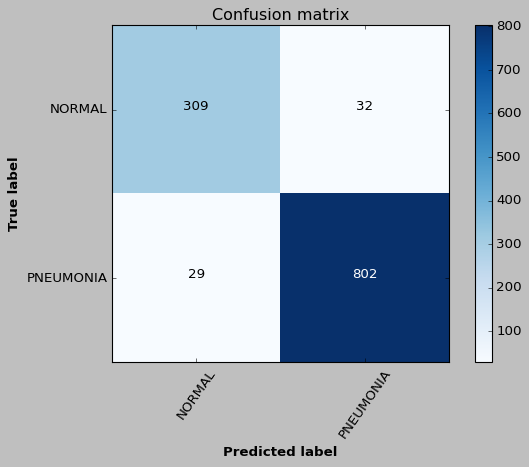

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plt.style.use('classic')
import itertools
from itertools import product

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, fontweight='bold'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    plt.tight_layout()

cm = confusion_matrix(y_test, predicted)


cm_plot_label = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion matrix')
plt.savefig('CM1',dpi=400)

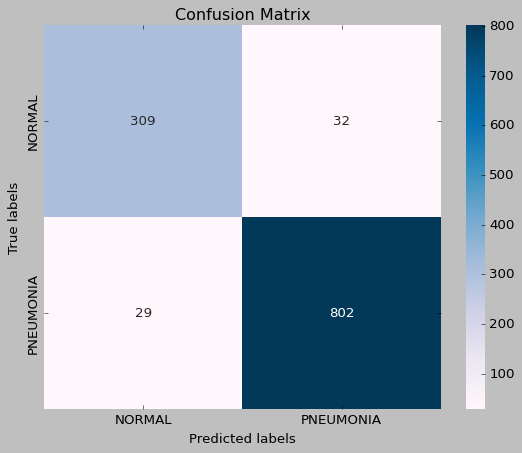

In [ ]:
import matplotlib.pyplot as plt

ax= plt.subplot()
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA']); ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
plt.savefig('CM_heatmap1',dpi=400)
plt.show()

<ipython-input-34-c6c642de1969>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


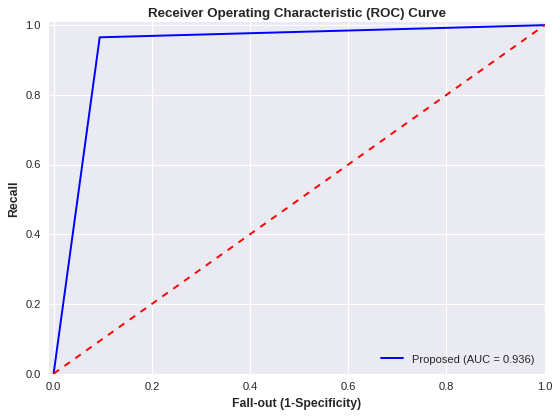

In [ ]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#Print Area Under Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
auc=metrics.auc(fpr, tpr)

plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.plot(fpr, tpr, 'b', label = 'Proposed (AUC = {:.3f})'.format(auc))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.01,1.0])
plt.ylim([0.0,1.01])
plt.ylabel('Recall', fontweight='bold')
plt.xlabel('Fall-out (1-Specificity)', fontweight='bold')
plt.savefig('AUC curve1',dpi=400)
plt.show()

In [ ]:
classes = ['NORMAL', 'PNEUMONIA']
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ROCAUC
from yellowbrick.style import set_palette

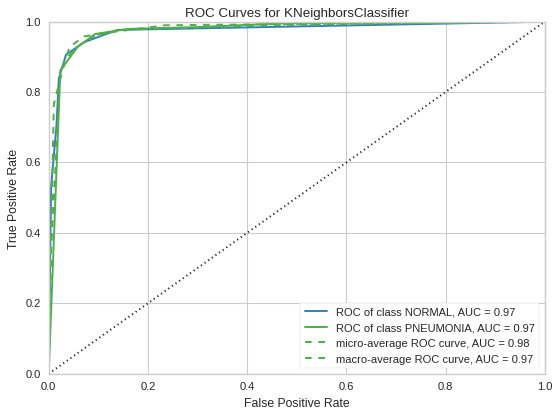

<Axes: title={'center': 'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
classes = ['NORMAL', 'PNEUMONIA']
visualizer = ROCAUC(knn, classes=classes)

set_palette('bold')

visualizer.fit(x_train, y_train)        # Fit the training data to the visualizer
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
plt.savefig('ROC curve1',dpi=400)
visualizer.show()

<a id='12'></a><br>
## SVM

In [ ]:
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly']}

SVM_grid = GridSearchCV(svm.SVC(), param_grid_svm, cv=5)
SVM_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']})

In [ ]:
print(SVM_grid.best_params_)

print(SVM_grid.best_estimator_)

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=10, gamma=0.0001)


In [ ]:
svm_clf = svm.SVC(C=10, gamma=0.0001, kernel='rbf')
svm_clf.fit(x_train,y_train)
predicted = svm_clf.predict(x_test)
score = svm_clf.score(x_test, y_test)
svm_score_ = np.mean(score)

print('Accuracy : %.5f' % (svm_score_))

Accuracy : 0.95819


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score,mean_squared_error

print('Accuracy: %.5f' % accuracy_score(y_test, predicted), 'Precision: %.5f' % precision_score(y_test, predicted),' Recall: %.5f' % recall_score(y_test, predicted), 'Error Rate: %.5f' % mean_squared_error(y_test, predicted),
      'F1 Score: %.5f' % f1_score(y_test, predicted), 'AUC Score: %.5f' % roc_auc_score(y_test, predicted))

Accuracy: 0.95819 Precision: 0.96437  Recall: 0.97714 Error Rate: 0.04181 F1 Score: 0.97071 AUC Score: 0.94458


Confusion matrix, without normalization
[[311  30]
 [ 19 812]]


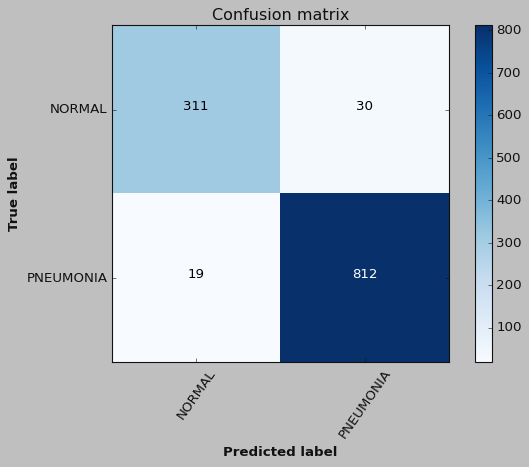

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plt.style.use('classic')
import itertools
from itertools import product

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, fontweight='bold'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    plt.tight_layout()

cm = confusion_matrix(y_test, predicted)


cm_plot_label = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion matrix')
plt.savefig('CM22',dpi=400)

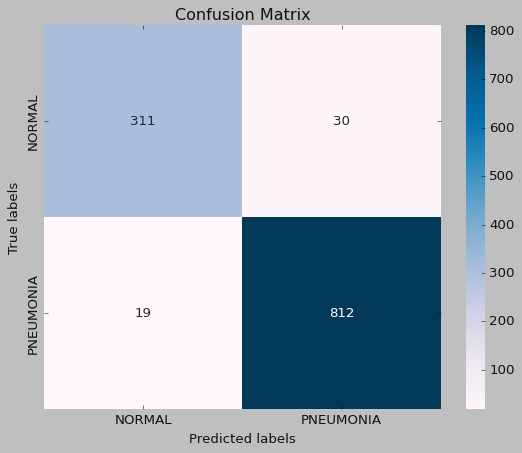

In [ ]:
import matplotlib.pyplot as plt

ax= plt.subplot()
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA']); ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
plt.savefig('CM_heatmap22',dpi=400)
plt.show()

<ipython-input-43-a2ce98955347>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


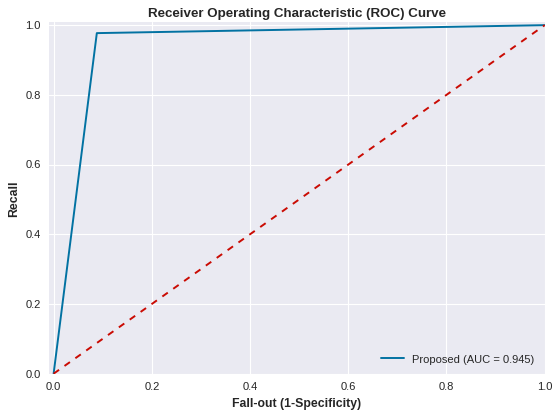

In [ ]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#Print Area Under Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
auc=metrics.auc(fpr, tpr)

plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.plot(fpr, tpr, 'b', label = 'Proposed (AUC = {:.3f})'.format(auc))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.01,1.0])
plt.ylim([0.0,1.01])
plt.ylabel('Recall', fontweight='bold')
plt.xlabel('Fall-out (1-Specificity)', fontweight='bold')
plt.savefig('AUC curve22',dpi=400)
plt.show()

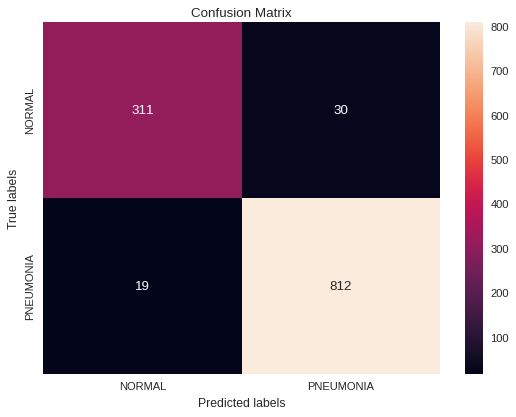

In [ ]:
import matplotlib.pyplot as plt

ax= plt.subplot()
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, annot=True, fmt='.0f')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA']); ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
plt.savefig('CM_heatmap23',dpi=400)
plt.show()

<a id='13'></a><br>
## Random Forest

In [ ]:
param_grid_rf = {
    'n_estimators': [200, 500],
    'max_depth' : [4,5,6,7,8]}

RF_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv= 5)
RF_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [200, 500]})

In [ ]:
print(RF_grid.best_params_)

{'max_depth': 8, 'n_estimators': 200}


In [ ]:
r_forest = RandomForestClassifier(200,max_depth=8, random_state=5)
r_forest.fit(x_train,y_train)
predicted = r_forest.predict(x_test)
score = r_forest.score(x_test, y_test)
rf_score_ = np.mean(score)

print('Accuracy : %.5f' % (rf_score_))

Accuracy : 0.91724


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
import seaborn as sns
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85       341
           1       0.93      0.96      0.94       831

    accuracy                           0.92      1172
   macro avg       0.91      0.89      0.90      1172
weighted avg       0.92      0.92      0.92      1172



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score,mean_squared_error

print('Accuracy: %.5f' % accuracy_score(y_test, predicted), 'Precision: %.5f' % precision_score(y_test, predicted),' Recall: %.5f' % recall_score(y_test, predicted), 'Error Rate: %.5f' % mean_squared_error(y_test, predicted),
      'F1 Score: %.5f' % f1_score(y_test, predicted), 'AUC Score: %.5f' % roc_auc_score(y_test, predicted))

Accuracy: 0.91724 Precision: 0.92974  Recall: 0.95548 Error Rate: 0.08276 F1 Score: 0.94243 AUC Score: 0.88976


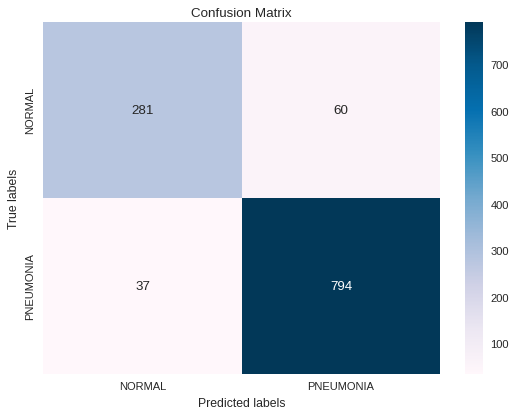

In [ ]:
import matplotlib.pyplot as plt

ax= plt.subplot()
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA']); ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
plt.savefig('CM_heatmap4',dpi=400)
plt.show()

<ipython-input-51-35c6ec2c20cc>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


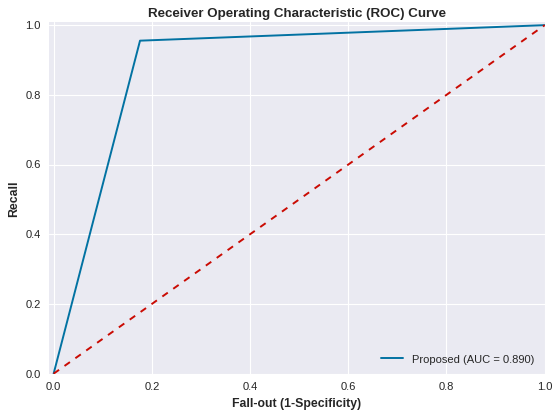

In [ ]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#Print Area Under Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
auc=metrics.auc(fpr, tpr)

plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.plot(fpr, tpr, 'b', label = 'Proposed (AUC = {:.3f})'.format(auc))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.01,1.0])
plt.ylim([0.0,1.01])
plt.ylabel('Recall', fontweight='bold')
plt.xlabel('Fall-out (1-Specificity)', fontweight='bold')
plt.savefig('AUC curve4',dpi=400)
plt.show()

<a id='14'></a><br>
## Naive Bayes

In [ ]:
nb_model = GaussianNB()
nb_model.fit(x_train,y_train)
predicted = nb_model.predict(x_test)
score = nb_model.score(x_test, y_test)
nb_score_ = np.mean(score)

print('Accuracy : %.5f' % (nb_score_))

Accuracy : 0.89249


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
import seaborn as sns
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       341
           1       0.97      0.88      0.92       831

    accuracy                           0.89      1172
   macro avg       0.86      0.90      0.88      1172
weighted avg       0.91      0.89      0.90      1172



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix, roc_curve, auc,roc_auc_score,mean_squared_error

print('Accuracy: %.5f' % accuracy_score(y_test, predicted), 'Precision: %.5f' % precision_score(y_test, predicted),' Recall: %.5f' % recall_score(y_test, predicted), 'Error Rate: %.5f' % mean_squared_error(y_test, predicted),
      'F1 Score: %.5f' % f1_score(y_test, predicted), 'AUC Score: %.5f' % roc_auc_score(y_test, predicted))

Accuracy: 0.89249 Precision: 0.96565  Recall: 0.87966 Error Rate: 0.10751 F1 Score: 0.92065 AUC Score: 0.90171


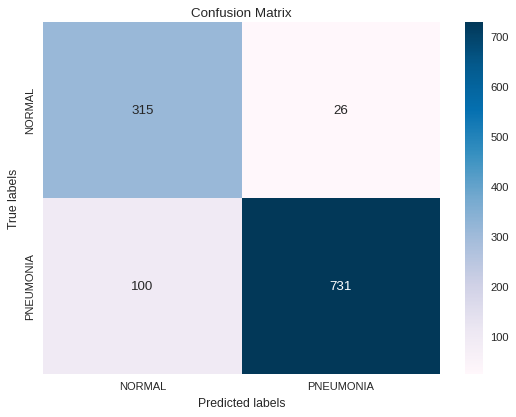

In [ ]:
import matplotlib.pyplot as plt

ax= plt.subplot()
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix, cmap="PuBu", annot=True, fmt='.0f')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA']); ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
plt.savefig('CM_heatmap5',dpi=400)
plt.show()

<ipython-input-56-abdb76e5e069>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


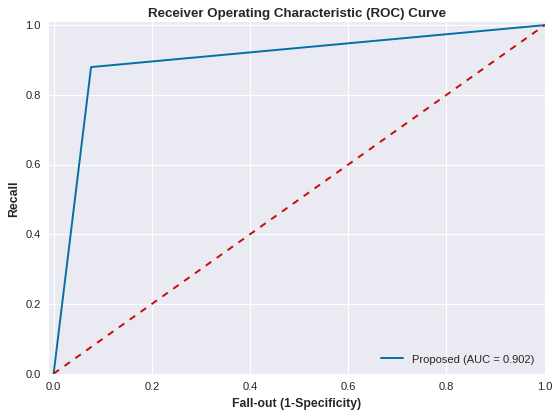

In [ ]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
plt.style.use('seaborn')
#Print Area Under Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
auc=metrics.auc(fpr, tpr)

plt.figure()
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.plot(fpr, tpr, 'b', label = 'Proposed (AUC = {:.3f})'.format(auc))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.01,1.0])
plt.ylim([0.0,1.01])
plt.ylabel('Recall', fontweight='bold')
plt.xlabel('Fall-out (1-Specificity)', fontweight='bold')
plt.savefig('AUC curve5',dpi=400)
plt.show()

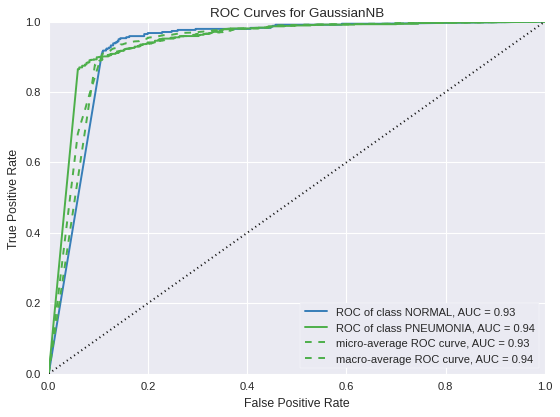

<Axes: title={'center': 'ROC Curves for GaussianNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
classes = ['NORMAL', 'PNEUMONIA']
visualizer = ROCAUC(nb_model, classes=classes)

set_palette('bold')

visualizer.fit(x_train, y_train)        # Fit the training data to the visualizer
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
plt.savefig('ROC curve5',dpi=400)
visualizer.show()